In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import LlamaTokenizer, LlamaForCausalLM
from datasets import load_dataset
from tqdm import tqdm

model_name = "meta-llama/Llama-2-7b-hf"

tokenizer = LlamaTokenizer.from_pretrained(model_name)
llama = LlamaForCausalLM.from_pretrained(model_name, do_sample=True).cuda()
for param in llama.parameters():
    param.requires_grad = False

tinystories = load_dataset("skeskinen/TinyStories-GPT4")['train']['story']

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
def next_token(model, input_ids):
    '''
    For a given model, this function calculates the next token probabilities and returns them.
    Also, it returns the memory coefficients, values, hidden states, and last hidden states for each layer.

    Input: model, input_ids (torch.tensor, tokenized)
    Output: next_token_probs (torch.tensor, probabilities of next token), MCVs (list of dicts)
    '''
    batch_size, seq_length = input_ids.shape

    seq_length_with_past = seq_length
    past_key_values_length = 0

    inputs_embeds = model.model.embed_tokens(input_ids)
    hidden_states = inputs_embeds

    position_ids = torch.arange(
        past_key_values_length, seq_length + past_key_values_length, dtype=torch.long
    ).cuda()
    position_ids = position_ids.unsqueeze(0).view(-1, seq_length)

    attention_mask = torch.ones(
        (batch_size, seq_length_with_past), dtype=torch.float
    ).cuda()
    attention_mask = model.model._prepare_decoder_attention_mask(
        attention_mask, (batch_size, seq_length), inputs_embeds, past_key_values_length
    ).cuda()

    MCVs = []

    for idx, decoder_layer in enumerate(model.model.layers):

        ### Attention ###

        input_layernorm = decoder_layer.input_layernorm
        self_attn = decoder_layer.self_attn

        residual = hidden_states
        hidden_states = input_layernorm(hidden_states)

        hidden_states, self_attn_weights, present_key_value = self_attn(
            hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
        )
        hidden_states = residual + hidden_states

        ########################################

        post_attention_layernorm = decoder_layer.post_attention_layernorm
        mlp = decoder_layer.mlp

        gate_proj = mlp.gate_proj
        up_proj = mlp.up_proj
        down_proj = mlp.down_proj
        act_fn = mlp.act_fn

        residual = hidden_states
        hidden_states = post_attention_layernorm(hidden_states)
        
        ### MLP ###
        MEMORY_COEFFICIENT = act_fn(gate_proj(hidden_states))
        VALUE = up_proj(hidden_states)
        hidden_states = down_proj(MEMORY_COEFFICIENT * VALUE)
        layer_num = idx + 1

        MCVs.append({
            'layer': layer_num,
            'sentence': tokenizer.decode(input_ids[0]),
            'memory_coefficient': MEMORY_COEFFICIENT[:, -1].cpu(),
            'value': VALUE[:, -1].cpu(),
            'hidden_state': hidden_states[:, -1].cpu(),
            'last_hidden_state': (residual + hidden_states)[:, -1].cpu(),
            'lm_head': (model.lm_head(model.model.norm(residual + hidden_states)))[:, -1].cpu(),
        })

        ########################################

        hidden_states = residual + hidden_states

    hidden_states = model.model.norm(hidden_states)
    x = model.lm_head(hidden_states)

    logits = x[:, -1]
    probs = torch.softmax(logits, dim=-1)

    return probs, MCVs

In [4]:
MC, V, HS = [[] for _ in range(12000)], [[] for _ in range(12000)], [[] for _ in range(12000)]

for sentence in tqdm(tinystories[30:10000]):
    input_ids = tokenizer.encode(sentence, return_tensors="pt").cuda()
    length = input_ids.shape[1]

    for i in range(20, length):
        probs, MCVs = next_token(llama, input_ids[:, :i])

        memory_coefficient = MCVs[-1]['memory_coefficient']
        max_index = torch.argmax(memory_coefficient).item()
        MC[max_index].append(MCVs[-1]['sentence'])

        value = MCVs[0]['value']
        max_index = torch.argmax(value).item()
        V[max_index].append(MCVs[-1]['sentence'])

        hidden_state = MCVs[0]['hidden_state']
        max_index = torch.argmax(hidden_state).item()
        HS[max_index].append(MCVs[-1]['sentence'])


  0%|          | 8/9970 [11:49<245:26:41, 88.70s/it]


KeyboardInterrupt: 

In [5]:
for i in range(len(MC)):
    if len(MC[i]) >= 1:
        print(i, "\n")

        for sentence in MC[i]:
            print(sentence, end='\n\n')

278 

<s>Lila and Ben were friends. They liked to play outside in the park. One day, it was very cold and windy. Lila had a colorful jacket. It was red and yellow and blue. Ben did not have a jacket. He only had a shirt and pants.
"Ben, you are cold. You need a jacket," Lila said.
"I don't have a jacket. My mom did not give me one," Ben said.
"That's not good. Here, you can have my jacket. It will protect you from the cold," Lila said. She took off her jacket and gave it to Ben.
"Thank you, Lila. You are very nice," Ben said. He put on the jacket and smiled.
They played for a while, but then they saw a big dog. The dog was angry and barked loud. It ran towards them.
"Run, Lila, run!" Ben shouted.
They ran, but the dog was faster. It caught up with them and bit Ben on the leg. Ben screamed and fell down. Lila was scared and cried.
"Help, help!" Lila shouted.
Some people heard them and came to help. They ch

<s>Lila and Ben were friends. They liked to play outside in the park. One day, i

In [3]:
from typing import List

def prob_distribution(x: str, y: List[str]):
    x = tokenizer.encode(x, return_tensors='pt').cuda()
    probs, MCVs = next_token(llama, x)

    token = torch.argmax(probs).item()
    print(token)
    print(tokenizer.decode(token))

    if not y:
        for token in [torch.argmax(MCVs[i]['lm_head'], dim=-1).item() for i in range(32)]:
            y.append(tokenizer.decode(token))
    y = list(set(y))

    test, dist = [], []
    for word in y:
        t = tokenizer(word, return_tensors='pt')['input_ids'][:, -1].item()
        test.append(t)

        d = [MCVs[i]['lm_head'][0][t] for i in range(32)]
        dist.append(d)

        plt.plot(d, label=word)
    
    plt.xlabel('Layer')
    plt.ylabel('Logits')
    plt.legend(loc='upper left')
    plt.show()

    test, dist = [], []
    for word in y:
        t = tokenizer(word, return_tensors='pt')['input_ids'][:, -1].item()
        test.append(t)

        d = [torch.softmax(MCVs[i]['lm_head'], dim=-1)[0][t] for i in range(32)]
        dist.append(d)
    
        plt.plot(d, label=word)
    
    plt.xlabel('Layer')
    plt.ylabel('Probabilities')
    plt.legend(loc='upper left')
    plt.show()

    for i in range(32):
        print(
            torch.argmax(MCVs[i]['lm_head'], dim=-1).item(),
            tokenizer.decode(
                torch.argmax(MCVs[i]['lm_head'], dim=-1).item()
            ), end="   "
        )

[] [tensor(0.5012), tensor(0.4975), tensor(0.5015), tensor(0.5026), tensor(0.4940), tensor(0.4924), tensor(0.5011), tensor(0.4998), tensor(0.4995), tensor(0.4987), tensor(0.5025), tensor(0.5018), tensor(0.5042), tensor(0.4955), tensor(0.5037), tensor(0.5029), tensor(0.5027), tensor(0.4975), tensor(0.5065), tensor(0.5052), tensor(0.5017), tensor(0.5015), tensor(0.4902), tensor(0.4995), tensor(0.5045), tensor(0.4978), tensor(0.4923), tensor(0.5030), tensor(0.5015), tensor(0.5055), tensor(0.4997), tensor(0.4996)] []


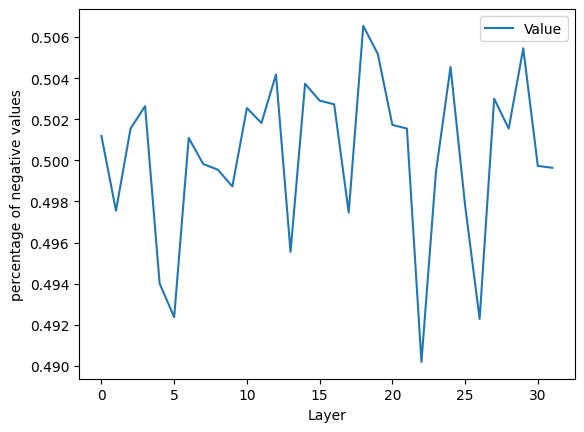

In [4]:
x = "The captial of France is the city of"
x = tokenizer.encode(x, return_tensors="pt").cuda()

probs, MCVs = next_token(llama, x)
out1, out2, out3, out4 = [], [], [], []
for MCV in MCVs:
    MC = MCV['memory_coefficient'].squeeze(0)
    V = MCV['value'].squeeze(0)
    HS = MCV['hidden_state'].squeeze(0)
    LHS = MCV['last_hidden_state'].squeeze(0)

    dim = MC.shape[0]
    # out1.append((MC <= 0).sum() / dim)
    out2.append((V <= 0).sum() / dim)
    # out3.append((HS <= -1).sum() / dim + (HS >= 1).sum() / dim)
    # out4.append((LHS <= 0).sum() / dim)


# plt.plot(out1, label="Memory Coefficient")
plt.plot(out2, label="Value")
# plt.plot(out3, label="Hidden State")
# plt.plot(out4, label="Last Hidden State")
plt.xlabel("Layer")
plt.ylabel("percentage of negative values")
plt.legend()

print(out1, out2, out3)

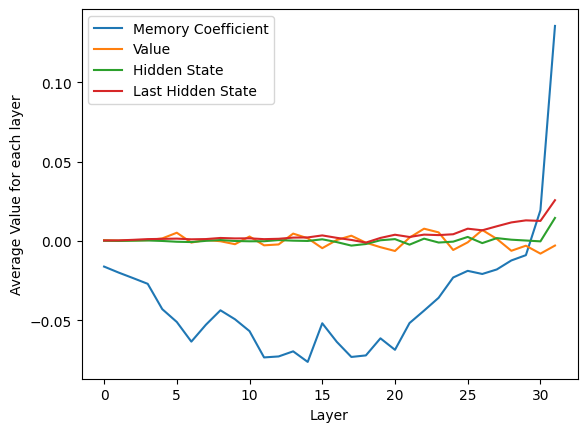

In [5]:
x = "The capital of France is the city of"
x = tokenizer.encode(x, return_tensors="pt").cuda()

probs, MCVs = next_token(llama, x)
out1, out2, out3, out4 = [], [], [], []
for MCV in MCVs:
    MC = MCV['memory_coefficient'].squeeze(0)
    V = MCV['value'].squeeze(0)
    HS = MCV['hidden_state'].squeeze(0)
    LHS = MCV['last_hidden_state'].squeeze(0)

    dim = MC.shape[0]
    out1.append(MC.sum() / dim)
    out2.append(V.sum() / dim)
    out3.append(HS.sum() / dim)
    out4.append(LHS.sum() / dim)

plt.plot(out1, label="Memory Coefficient")
plt.plot(out2, label="Value")
plt.plot(out3, label="Hidden State")
plt.plot(out4, label="Last Hidden State")
plt.xlabel("Layer")
plt.ylabel("Average Value for each layer")
plt.legend()

/tmp/ipykernel_1129460/516739294.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 10))


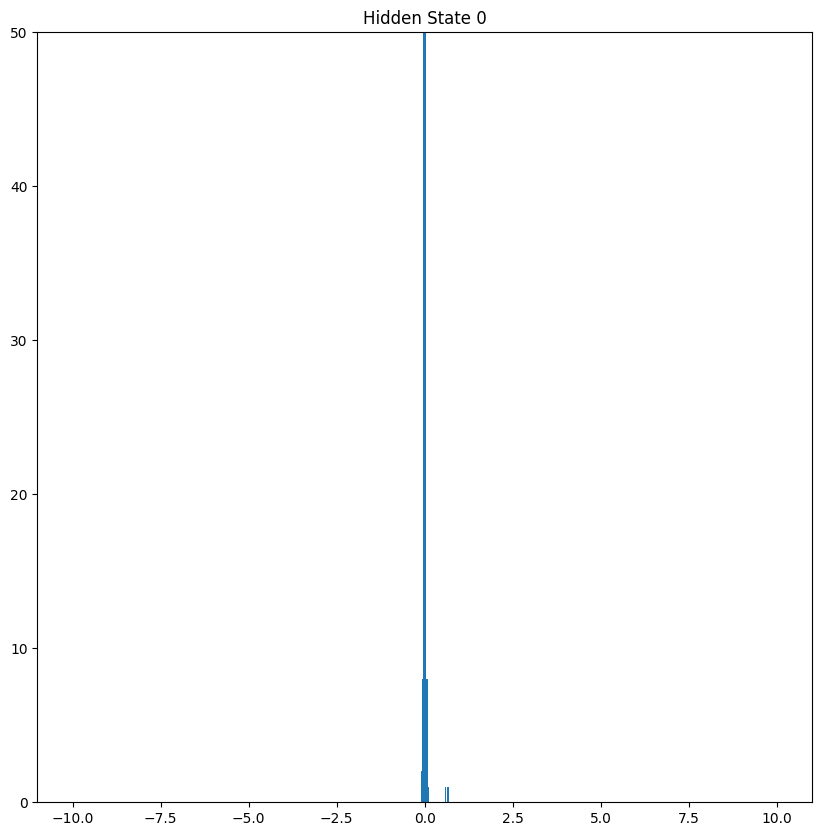

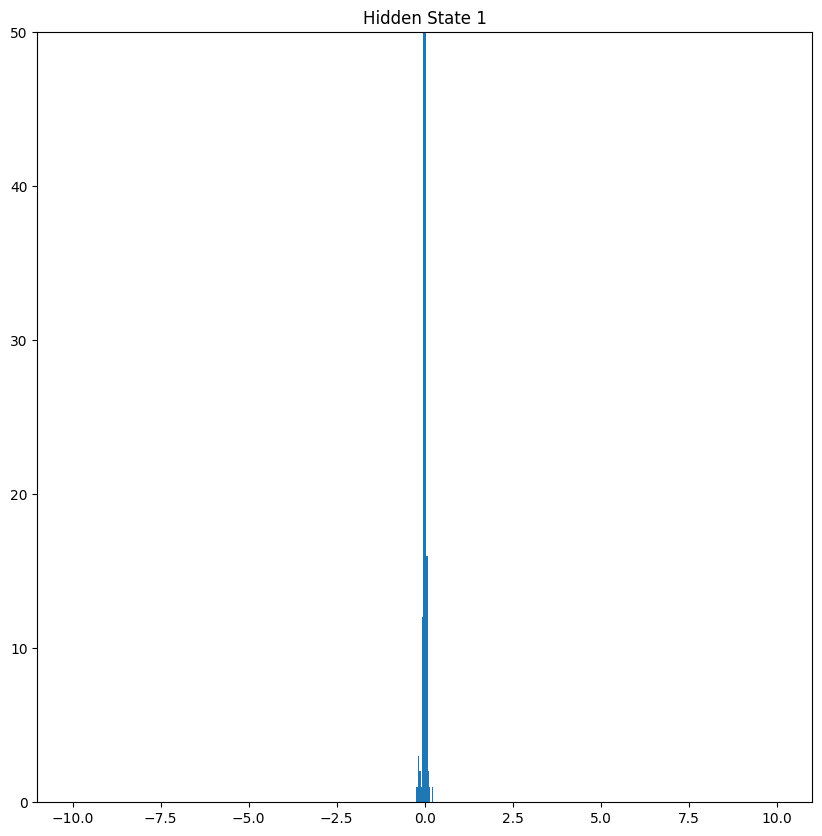

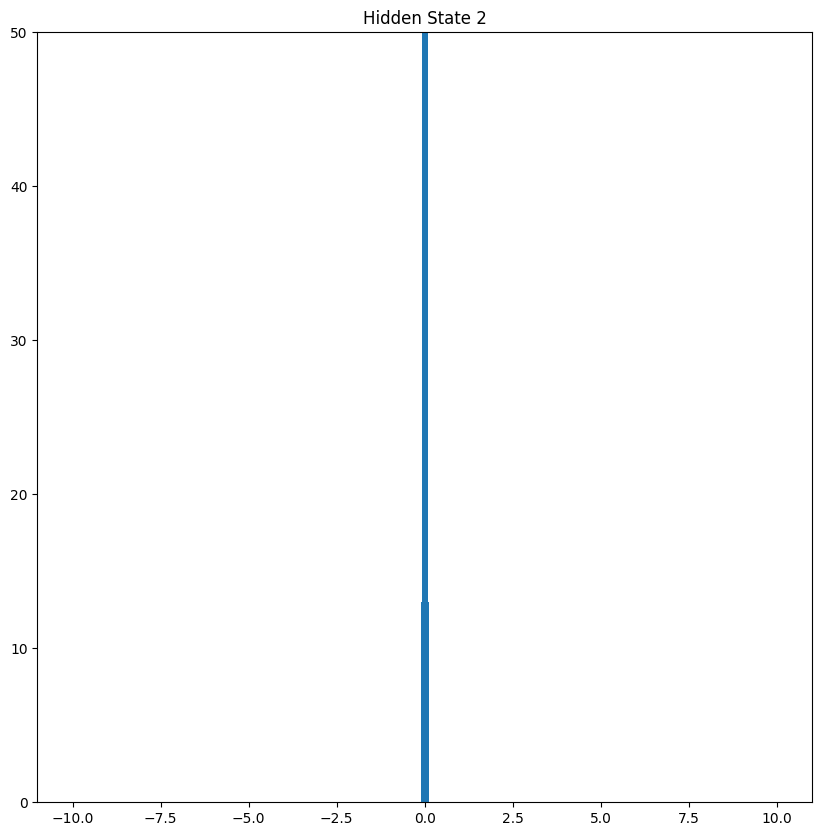

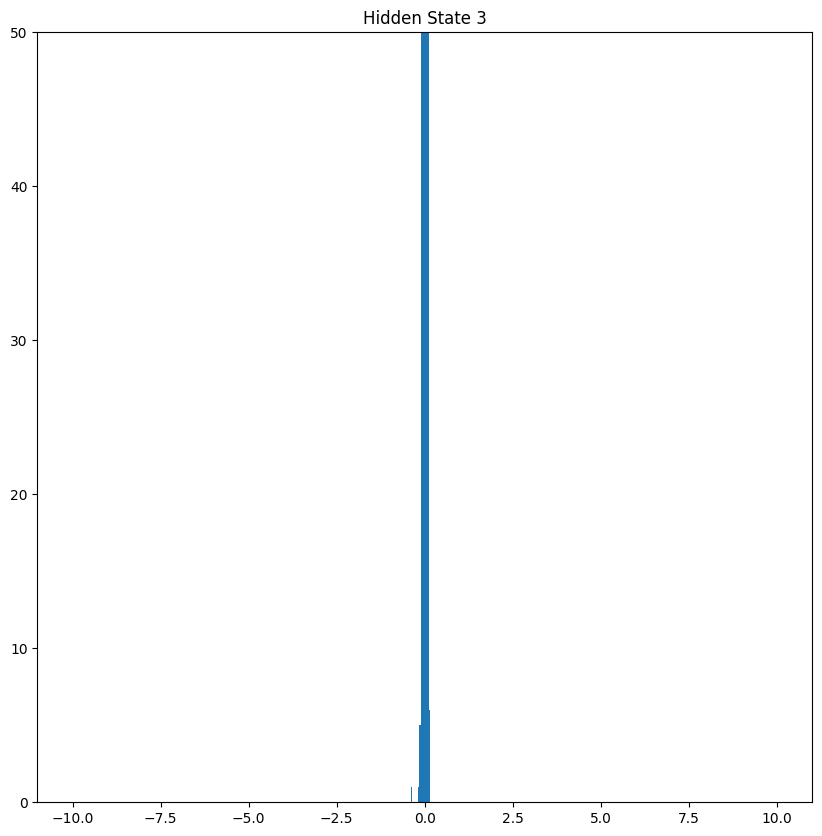

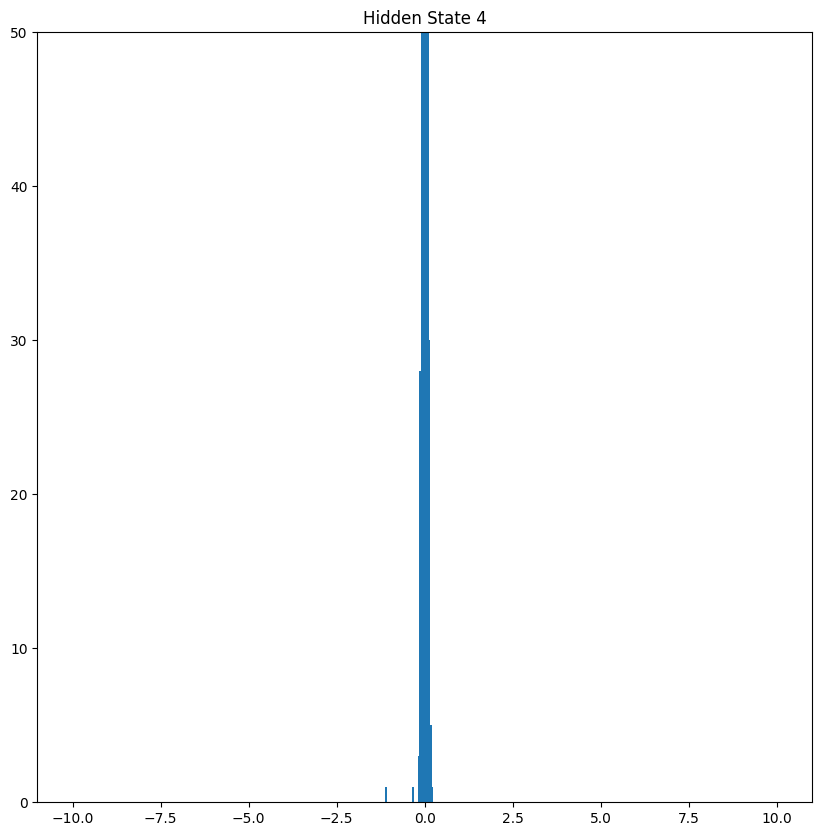

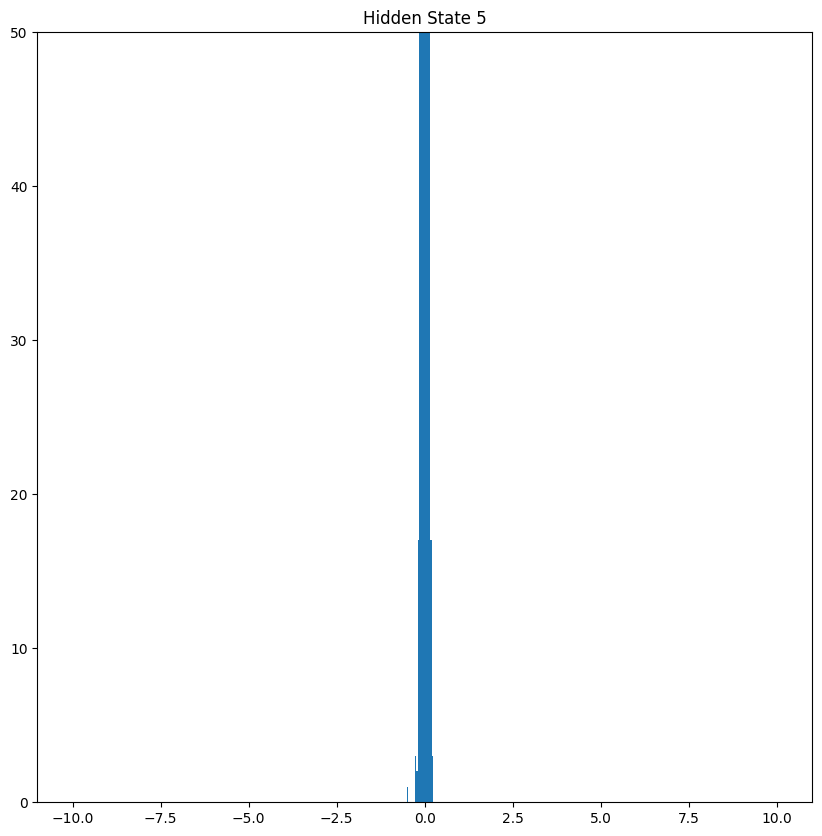

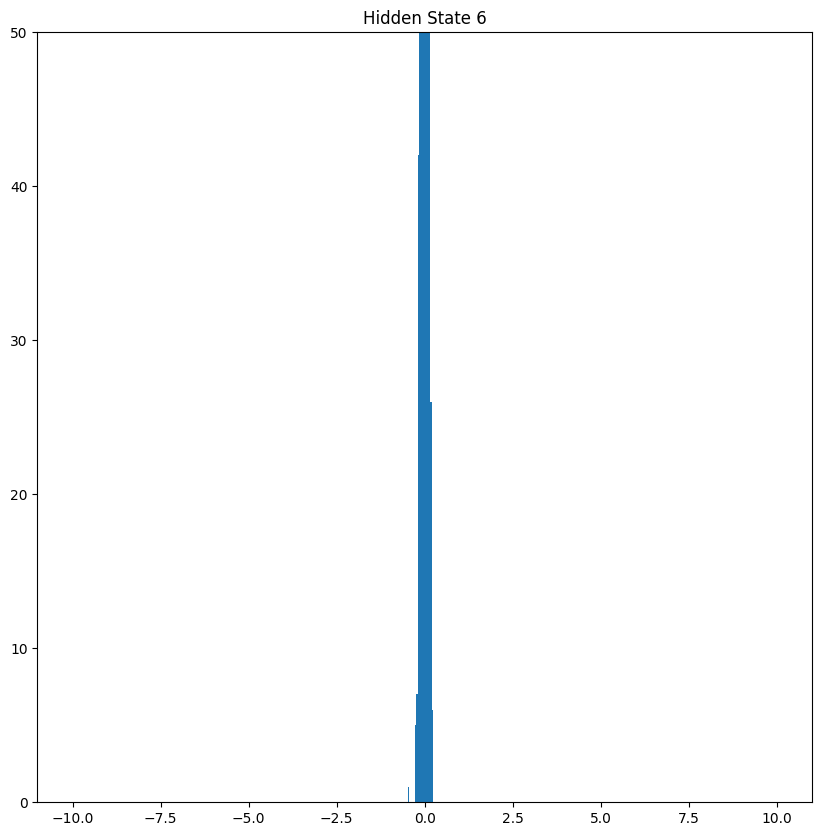

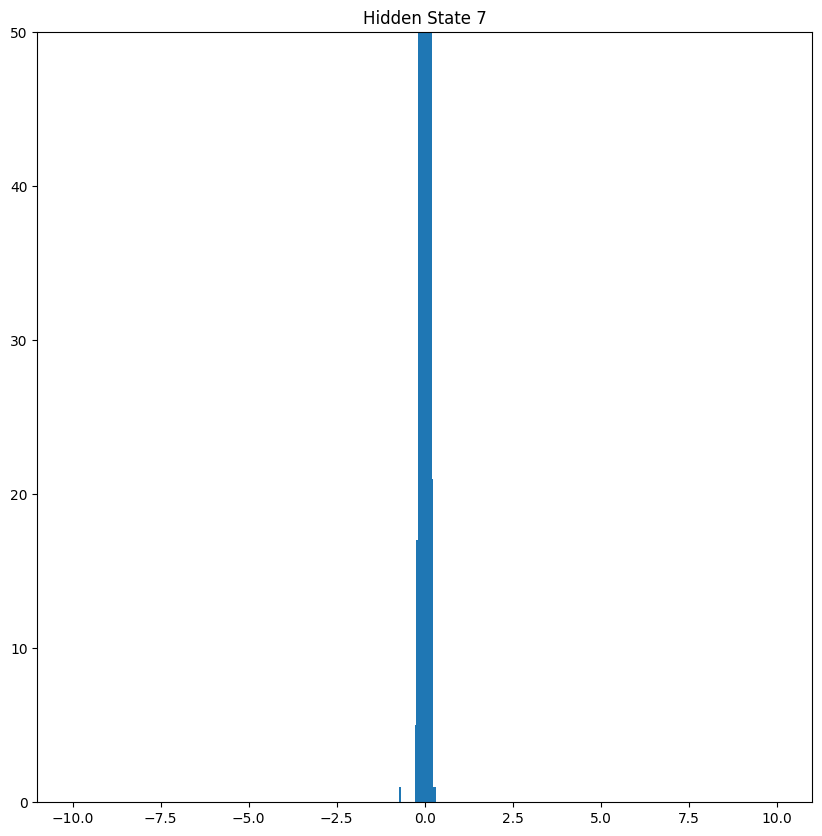

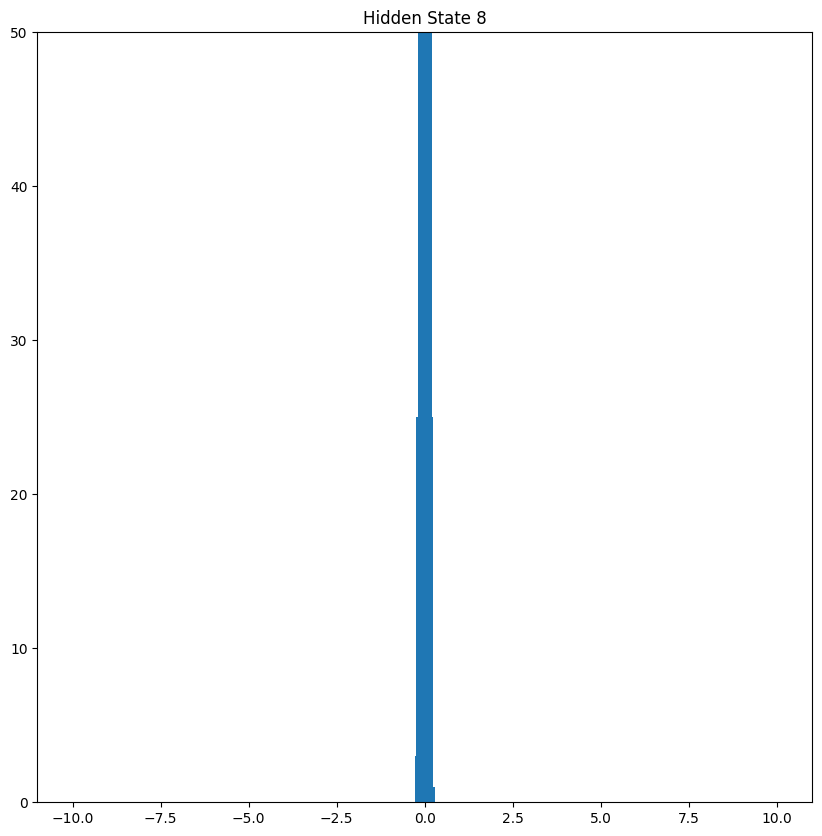

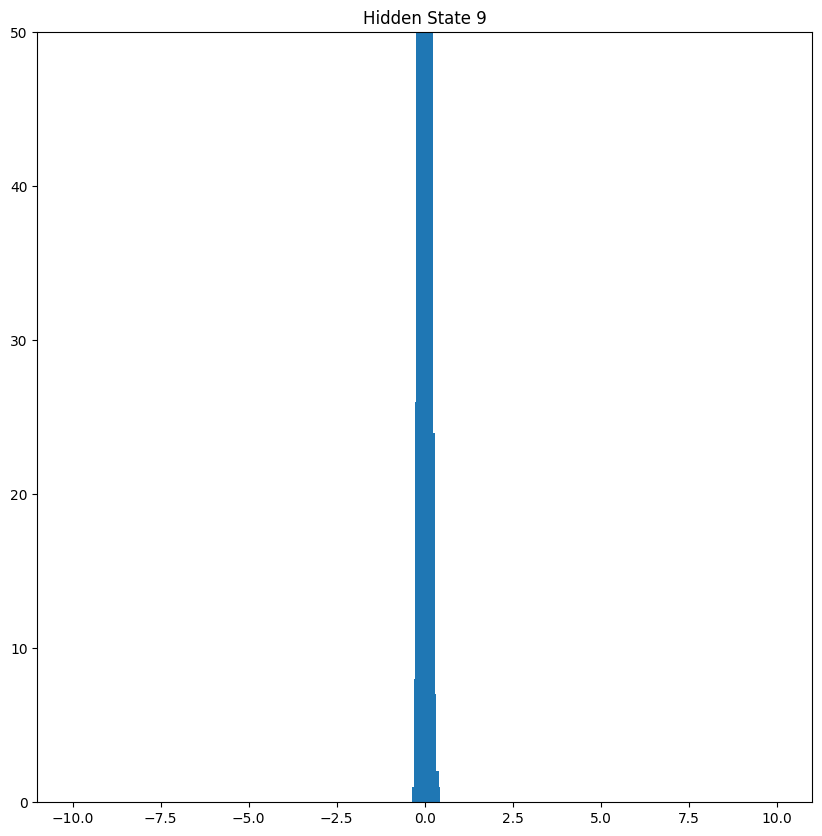

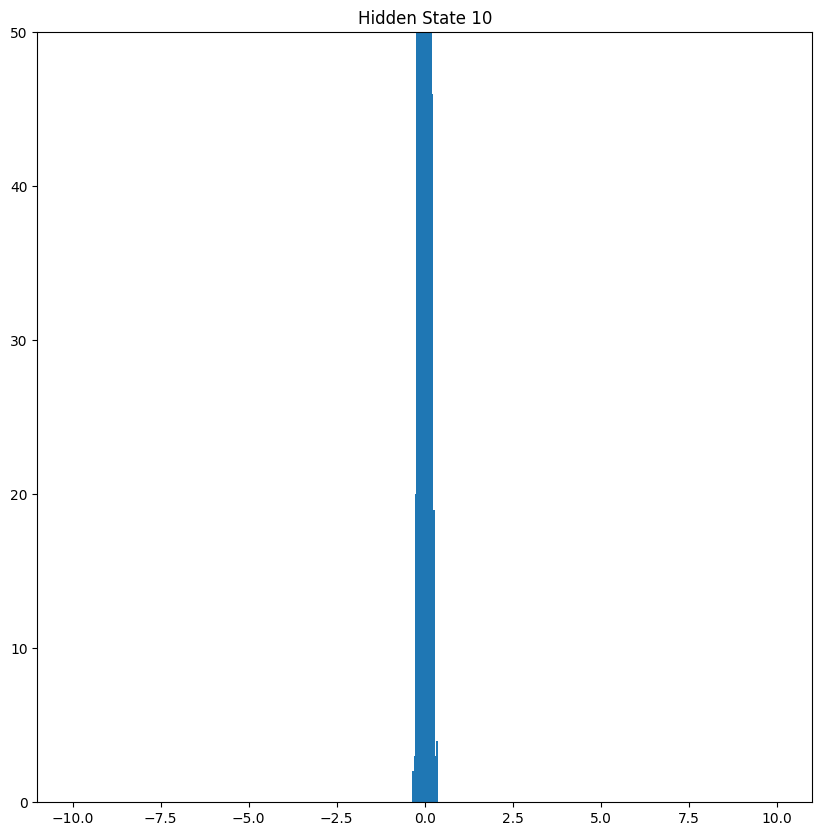

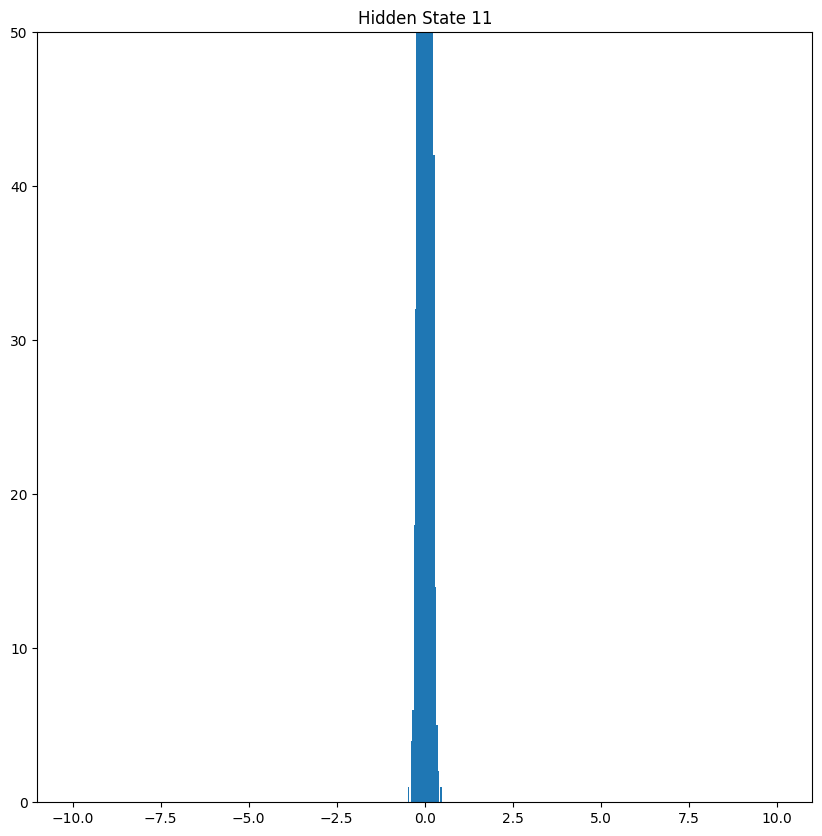

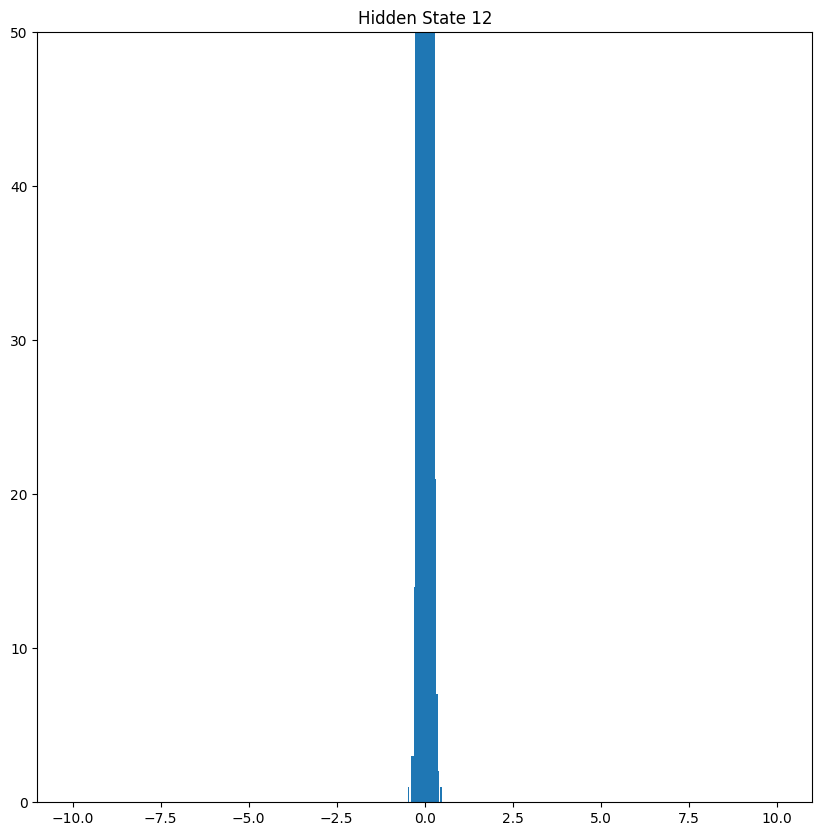

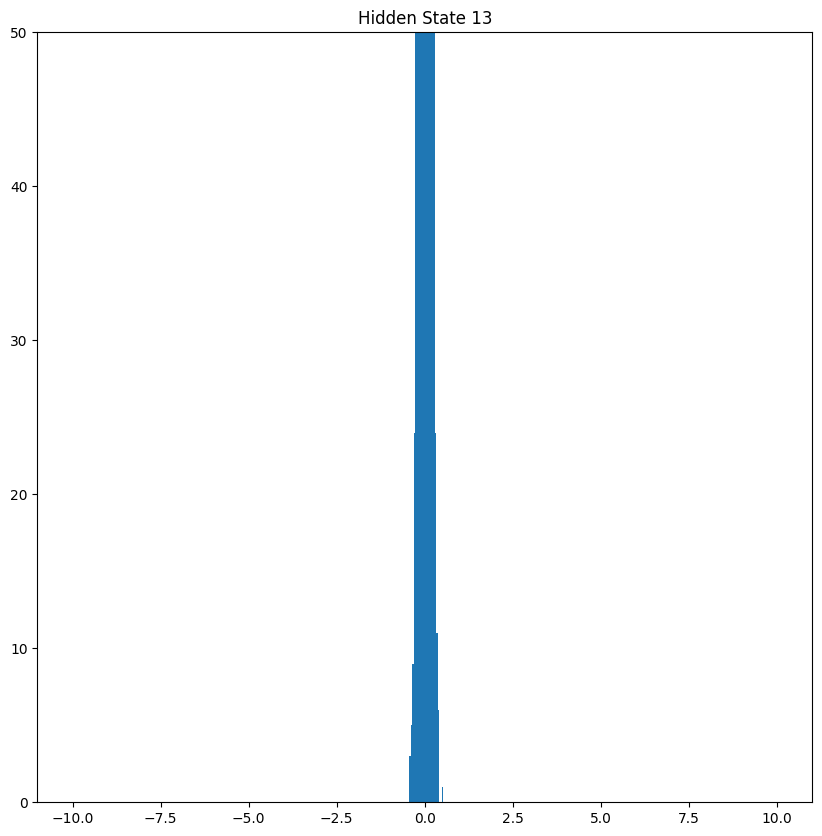

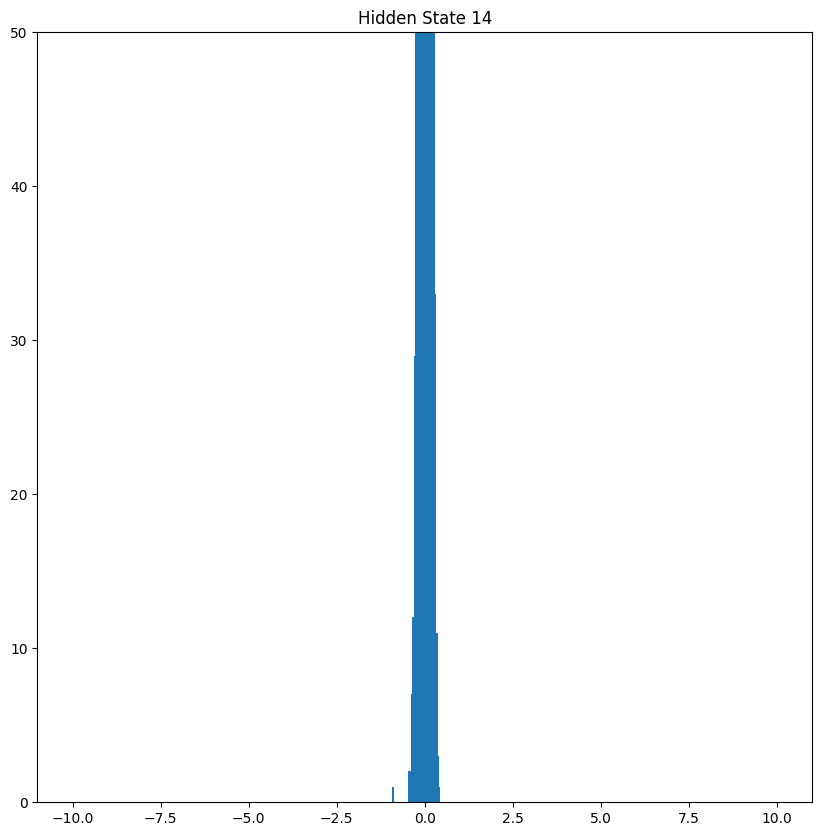

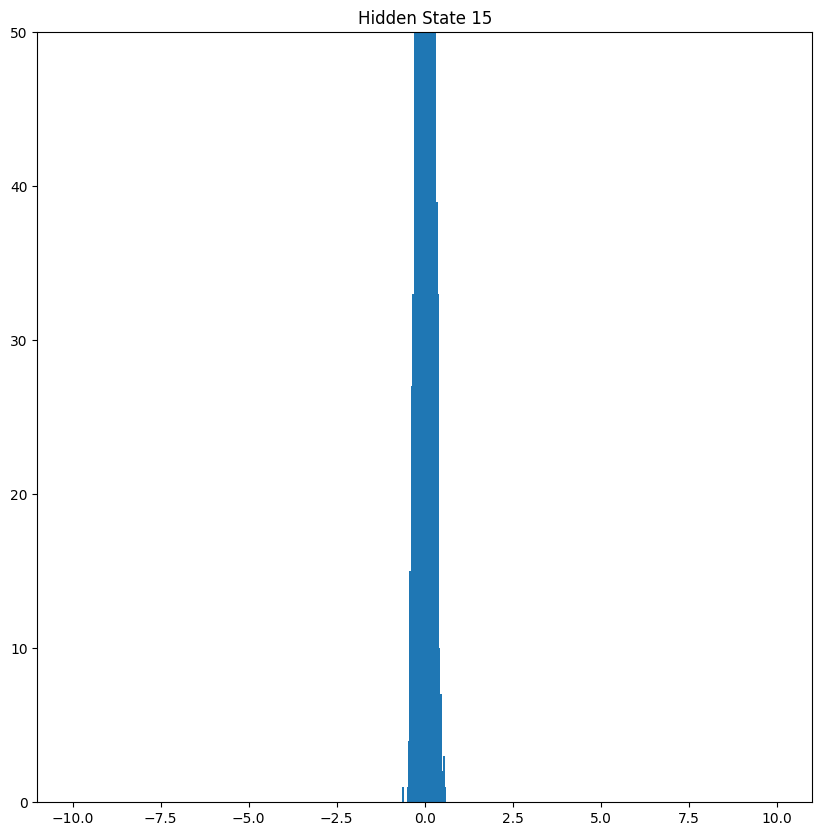

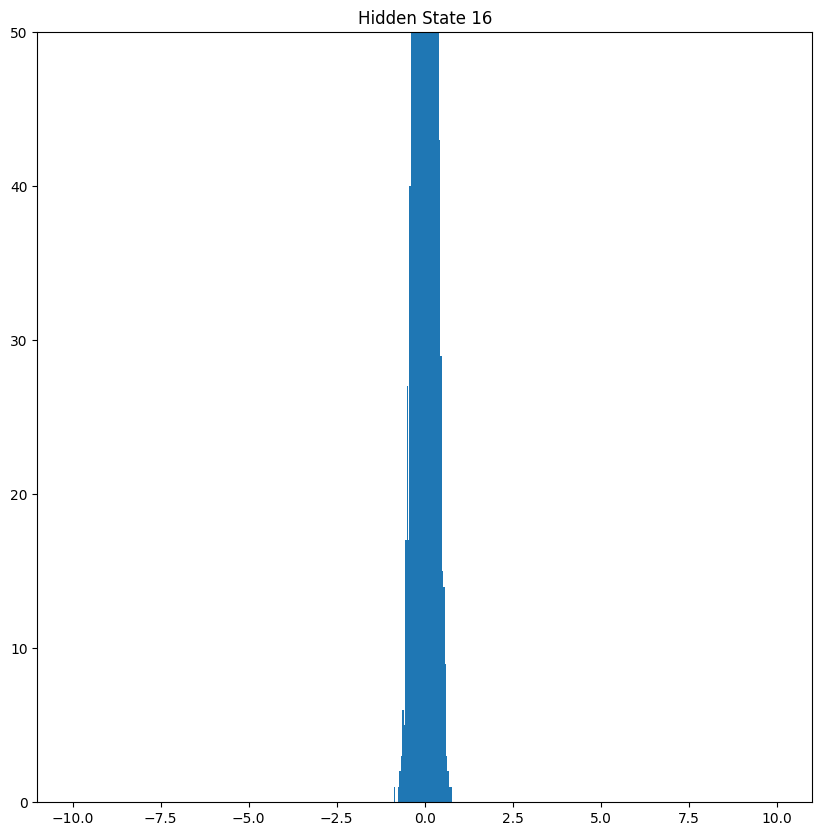

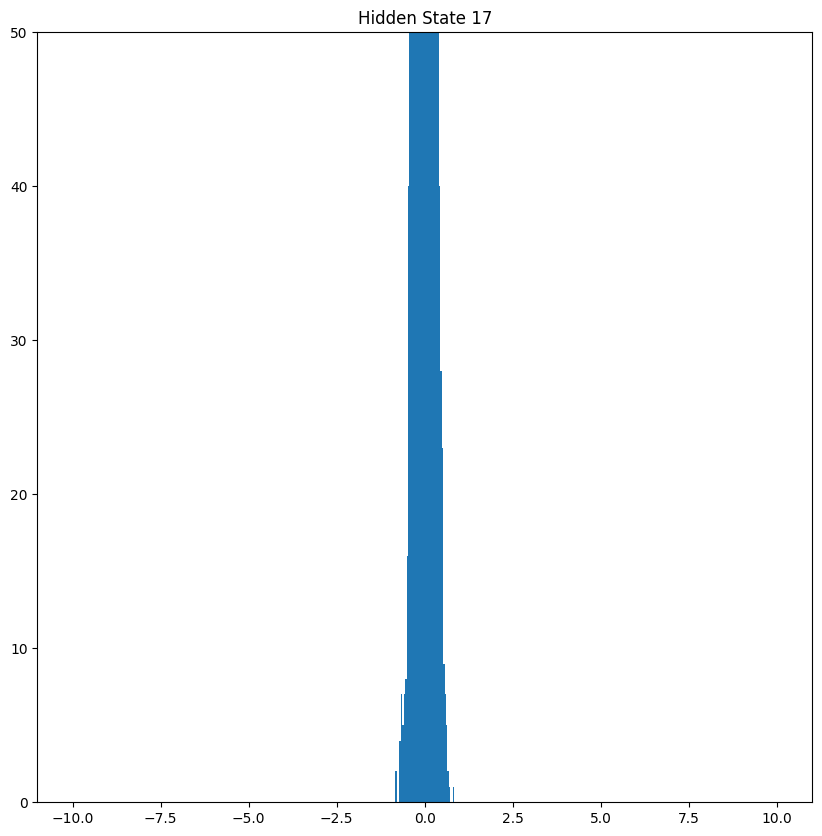

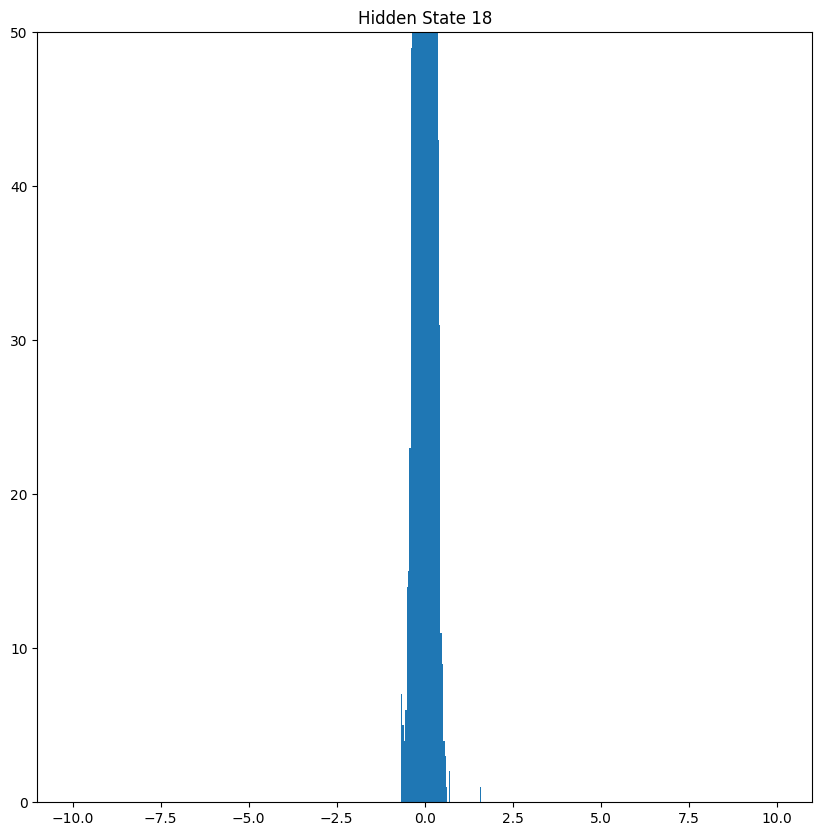

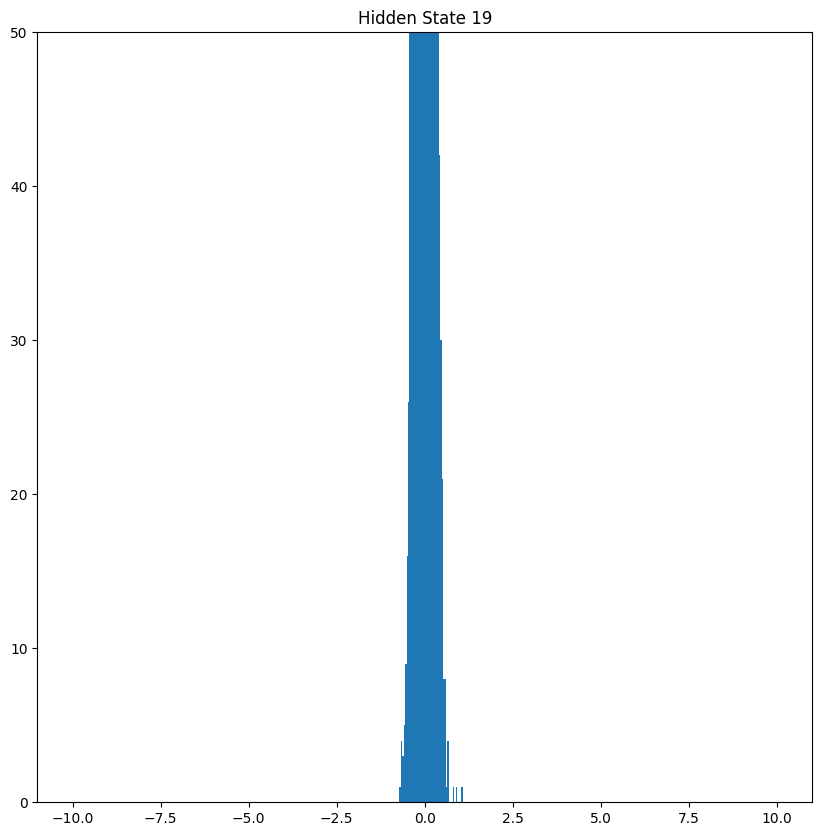

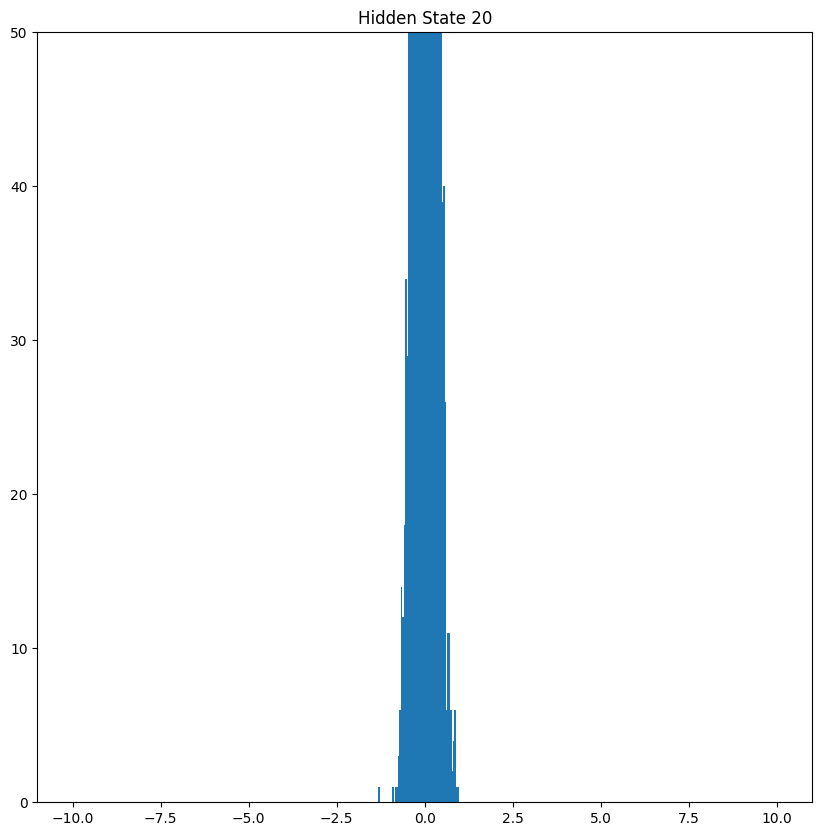

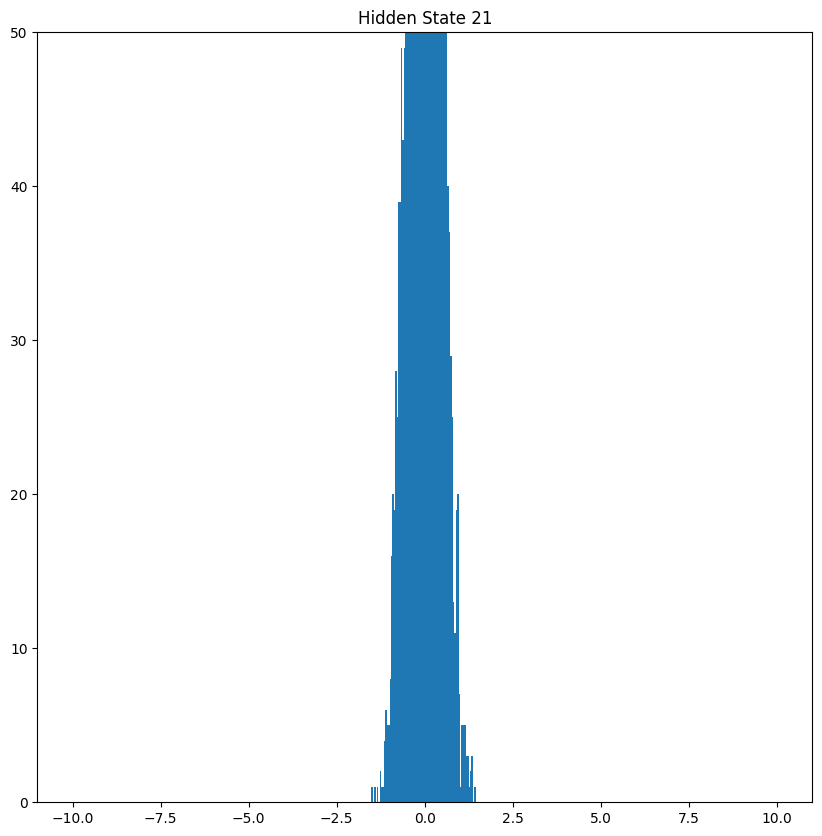

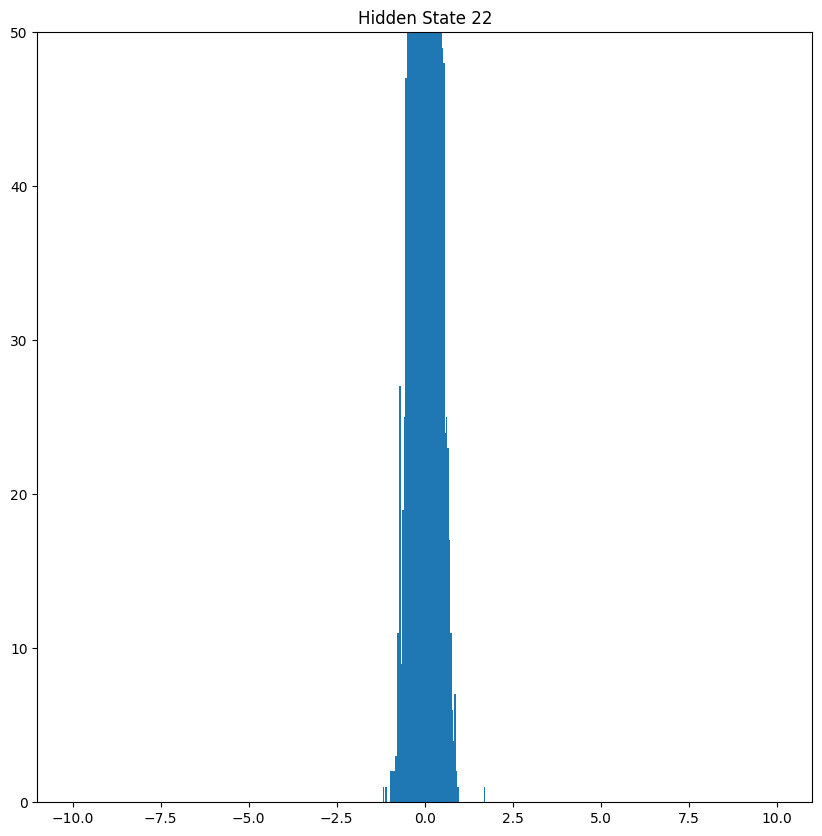

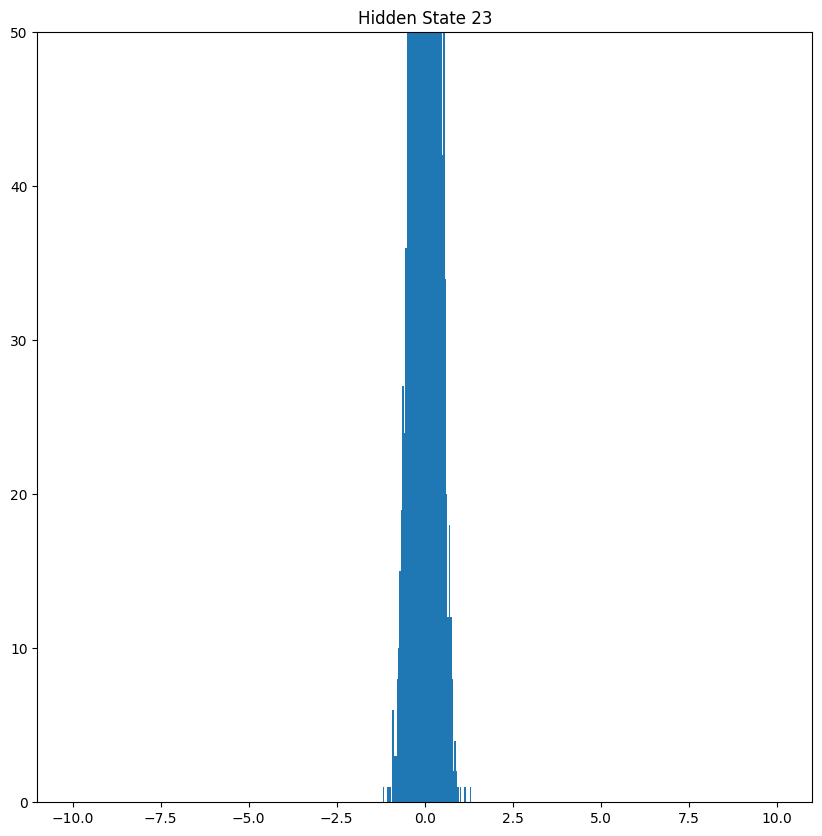

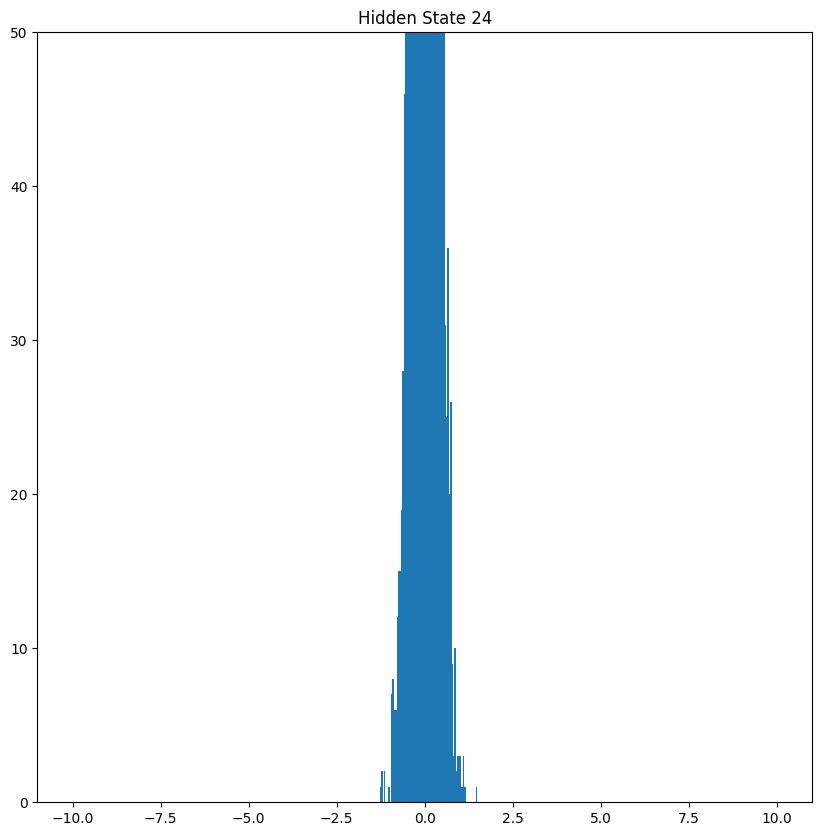

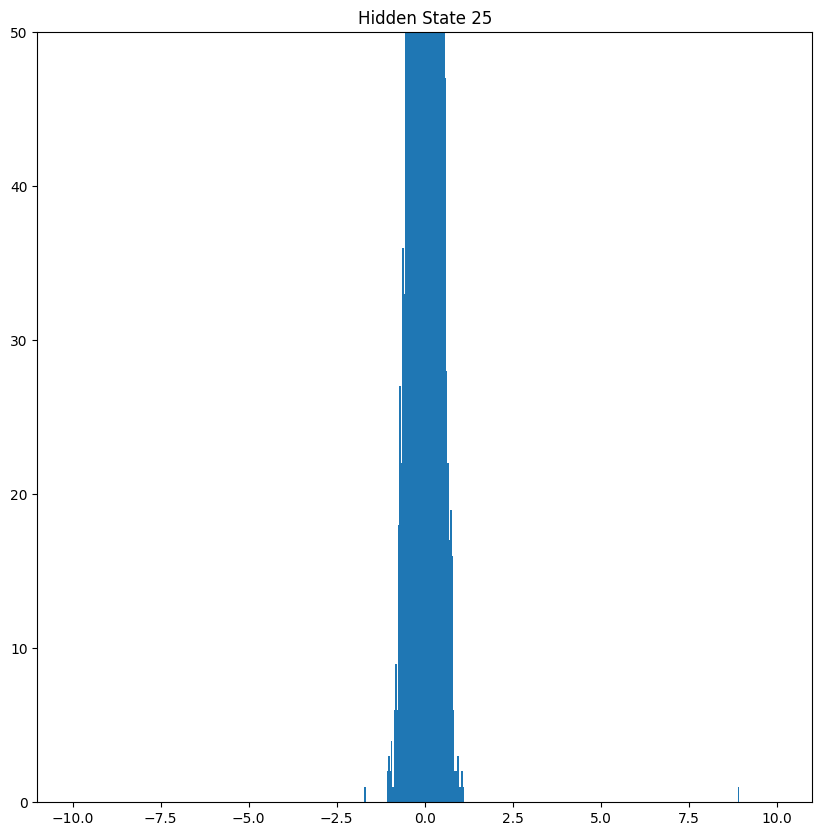

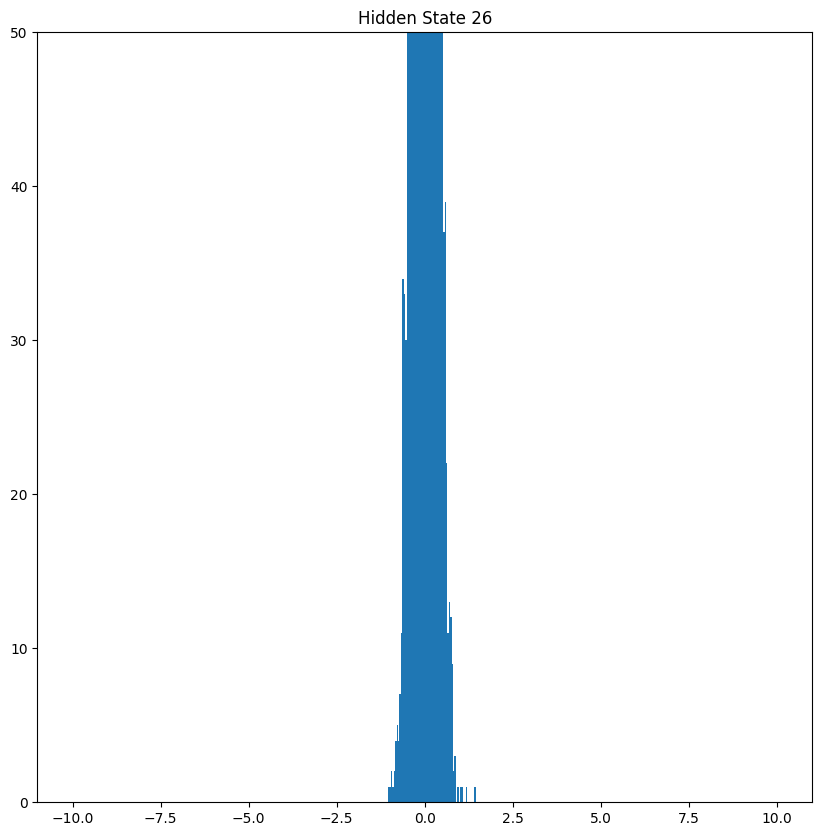

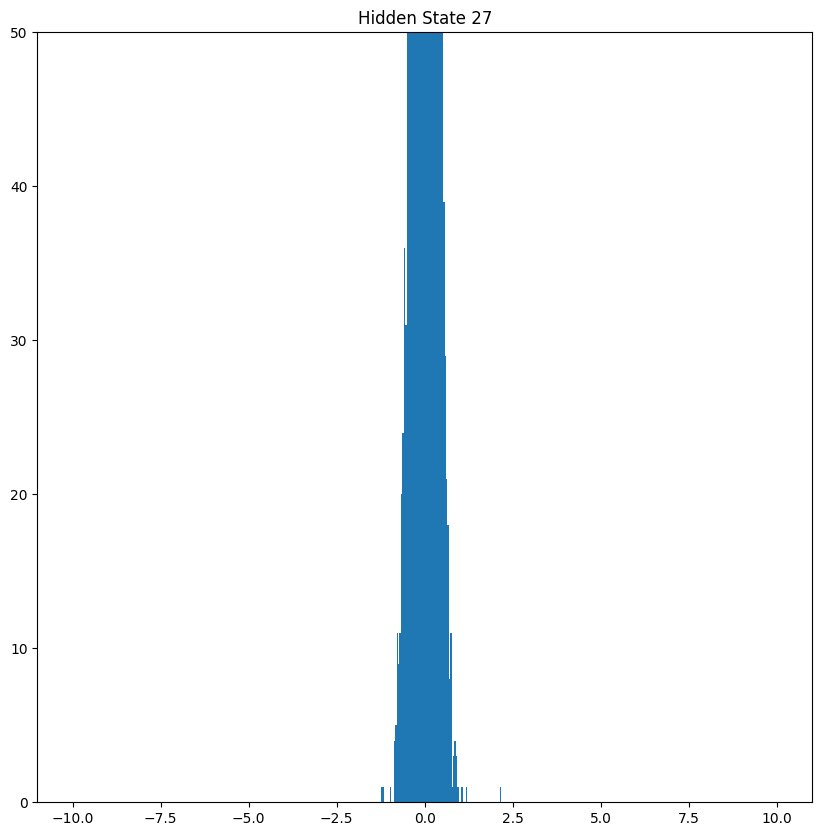

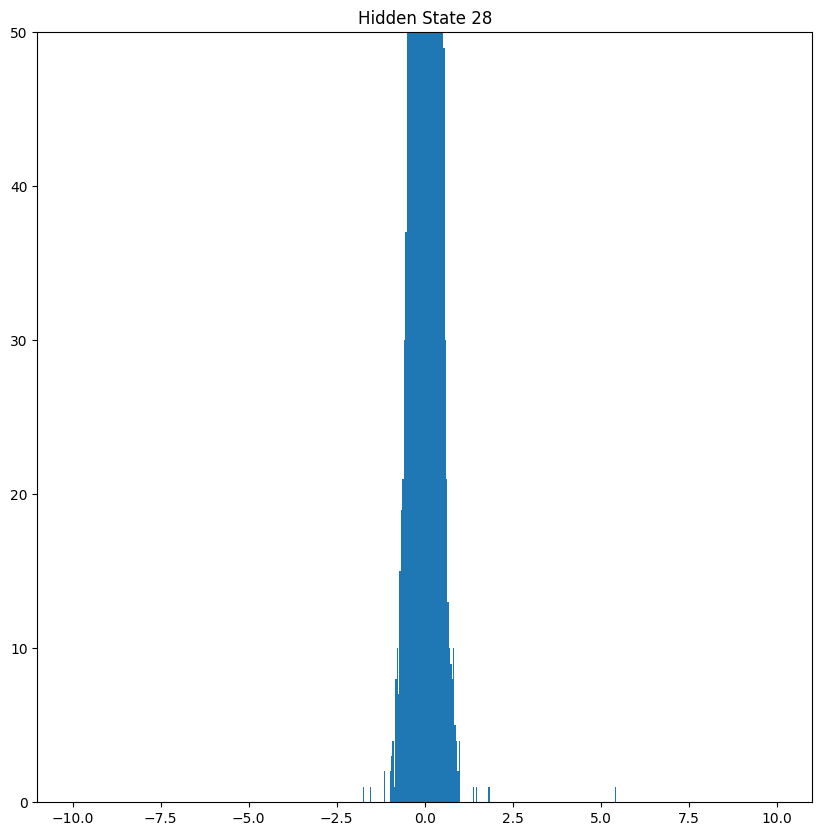

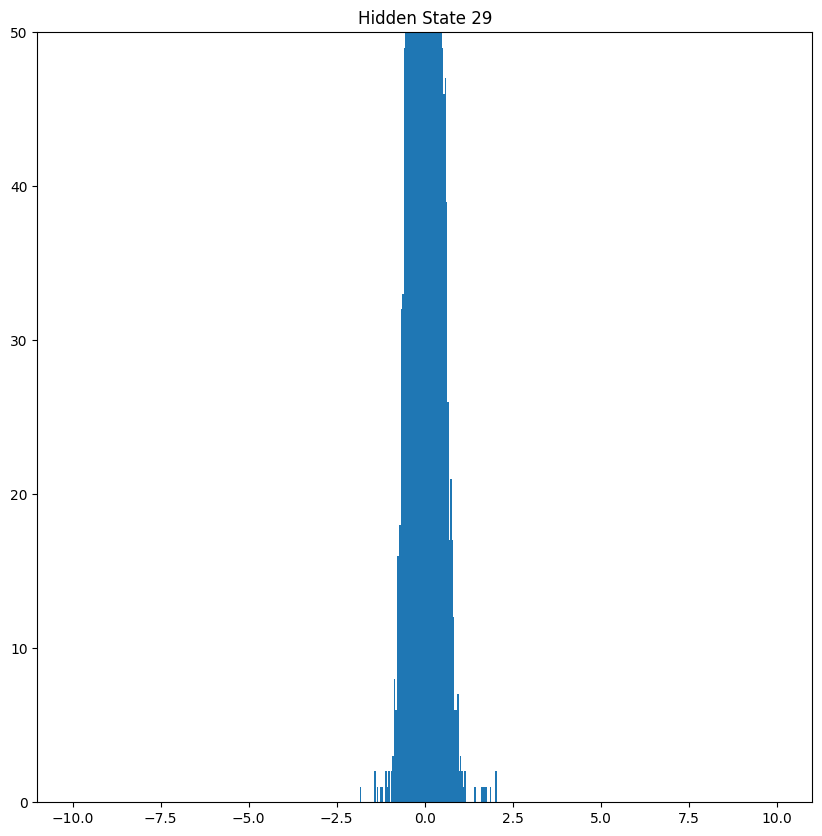

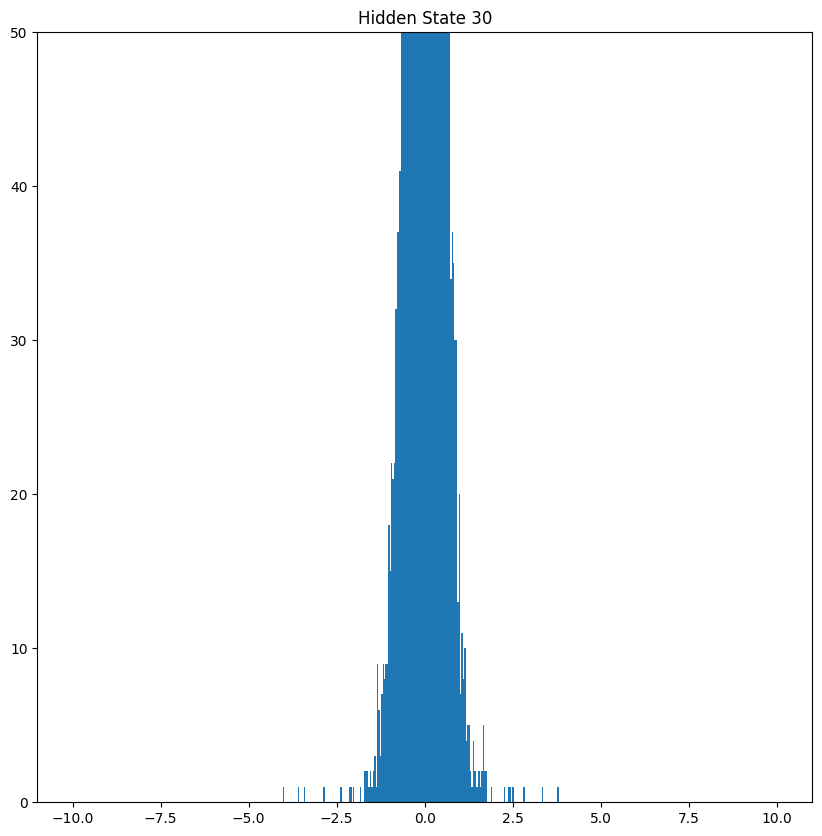

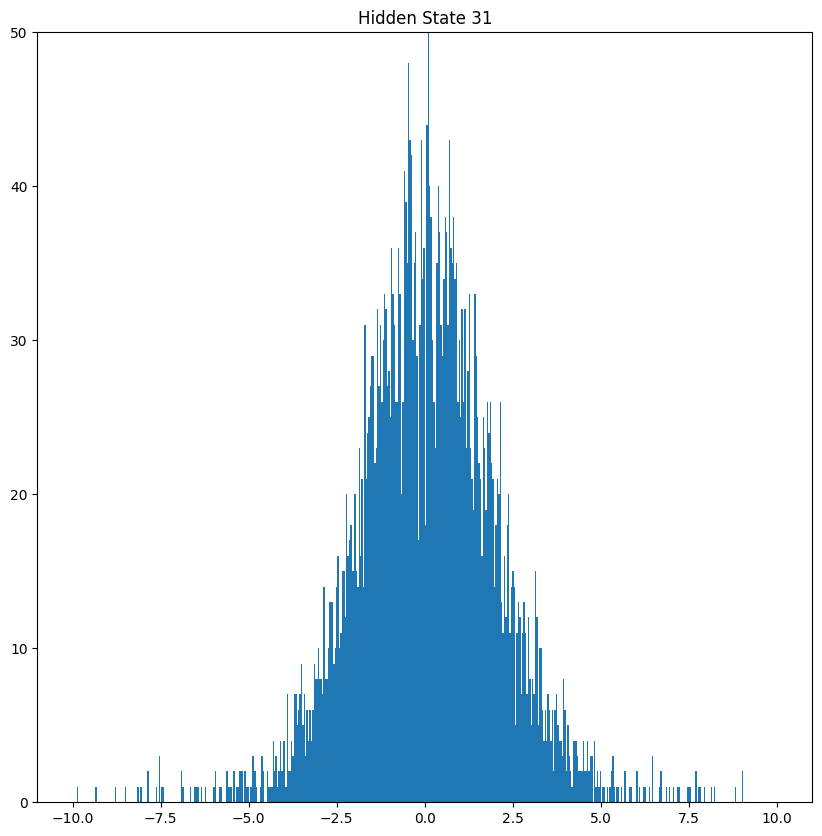

In [83]:
x = "The capital of France is the city of"
x = tokenizer.encode(x, return_tensors="pt").cuda()

probs, MCVs = next_token(llama, x)
out1, out2, out3, out4 = [], [], [], []
for MCV in MCVs:
    MC = MCV['memory_coefficient'].squeeze(0)
    V = MCV['value'].squeeze(0)
    HS = MCV['hidden_state'].squeeze(0)
    LHS = MCV['last_hidden_state'].squeeze(0)

    dim = MC.shape[0]
    # out1.append(MC)
    # out2.append(V)
    out3.append(HS)
    # out4.append(LHS)

for i in range(len(out3)):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.hist(out3[i].cpu().numpy(), bins=500, range=(-10, 10))
    ax.set_ylim(0, 50)
    ax.set_title(f"Hidden State {i}")

    # savefig
    plt.savefig(f"./img/{i}.png")

In [32]:
x = tokenizer.encode("Seoul")
print(x)

for token in x[1:]:
    print(tokenizer.decode([token]))

[1, 922, 5059]
Se
oul


5059
oul


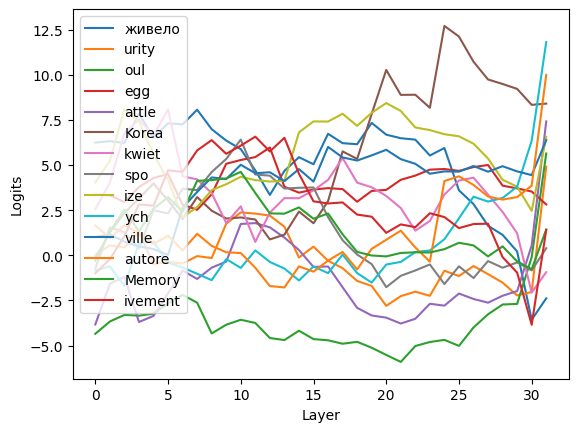

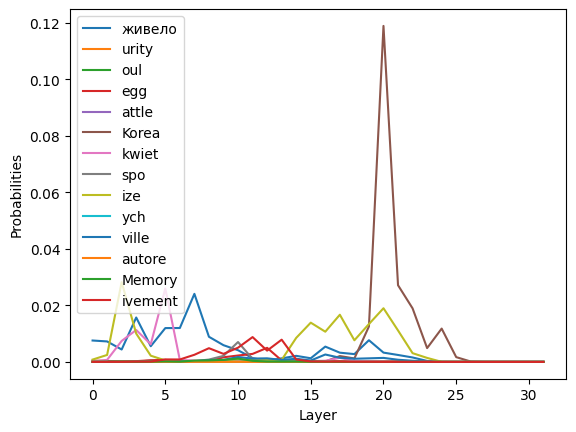

3376 ych   5059 oul   675 ize   5059 oul   28629 autore   25145 kwiet   23996 живело   23996 живело   23996 живело   16015 Memory   13345 spo   19882 ivement   19710 egg   19882 ivement   5315 attle   5315 attle   7710 urity   4909 ville   5315 attle   5315 attle   19109 Korea   5059 oul   5059 oul   5059 oul   5059 oul   5059 oul   5059 oul   5059 oul   5059 oul   5059 oul   5059 oul   5059 oul   

In [6]:
prob_distribution("The capital of South Korea is the city of Se", [])

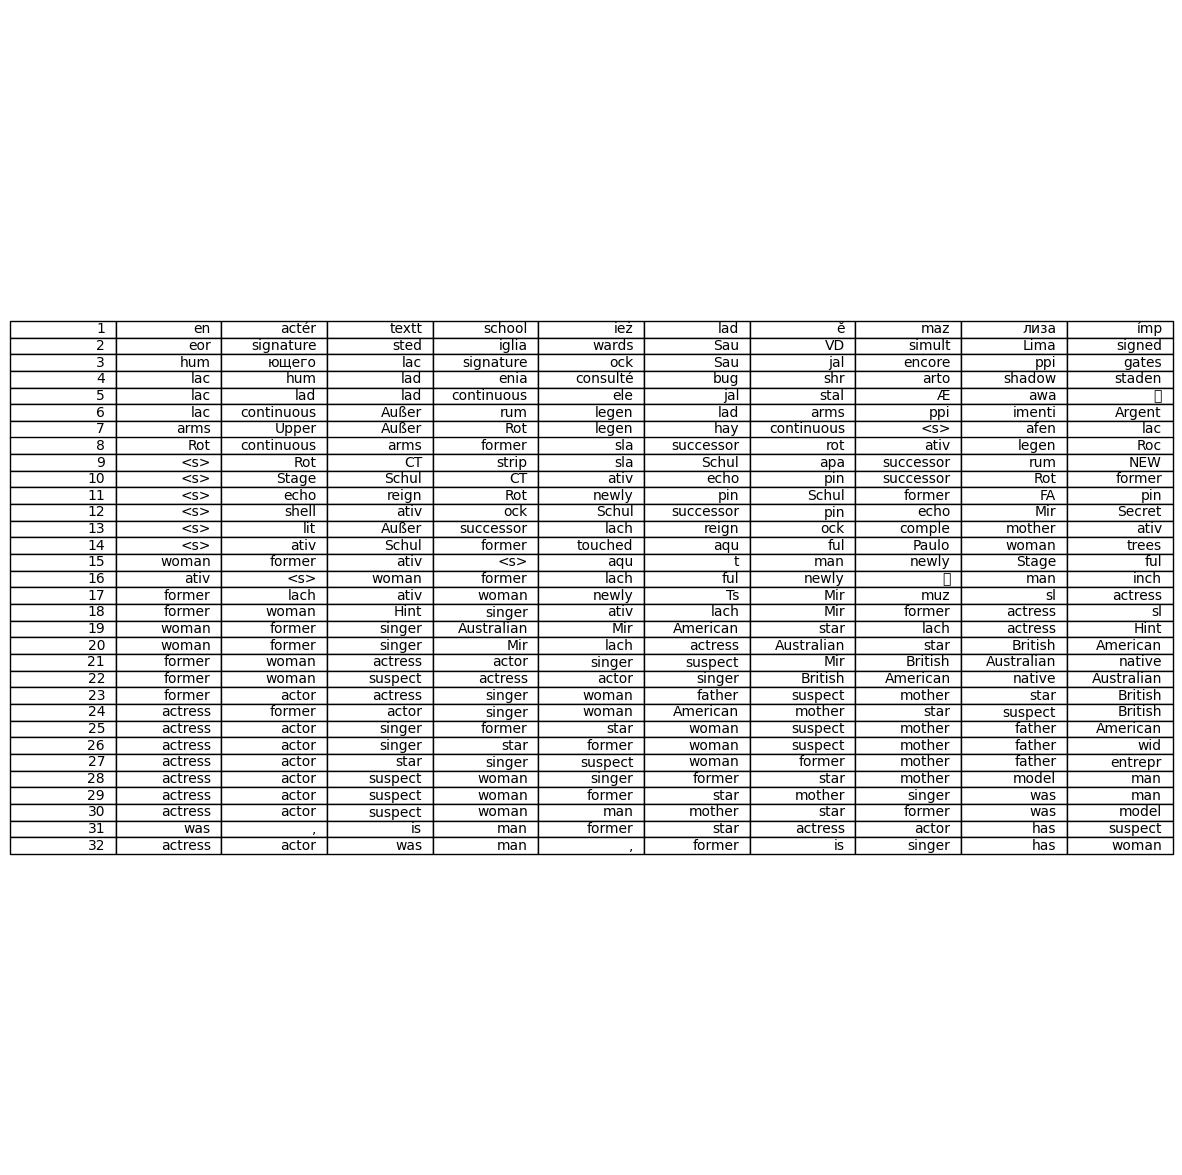

In [92]:
x = "The 49-year-old"
x = tokenizer.encode(x, return_tensors="pt").cuda()
probs, MCVs = next_token(llama, x)

probs = [torch.softmax(MCVs[i]['lm_head'], dim=-1) for i in range(len(MCVs))]

out = [[] for _ in range(len(probs))]

for i in range(len(probs)):
    # print topk
    values, indicies = torch.topk(probs[i], 10)

    out[i].append(i + 1)
    for token in indicies[0]:
        out[i].append(tokenizer.decode([token]))
    
plt.figure(figsize=(15, 15))
plt.table(out, loc='center')
plt.axis('off')
plt.show()

In [ ]:
x = "This cake is so"
x = tokenizer.encode(x, return_tensors="pt").cuda()
print(tokenizer.decode(llama.generate(x, max_length=30).squeeze().tolist()))

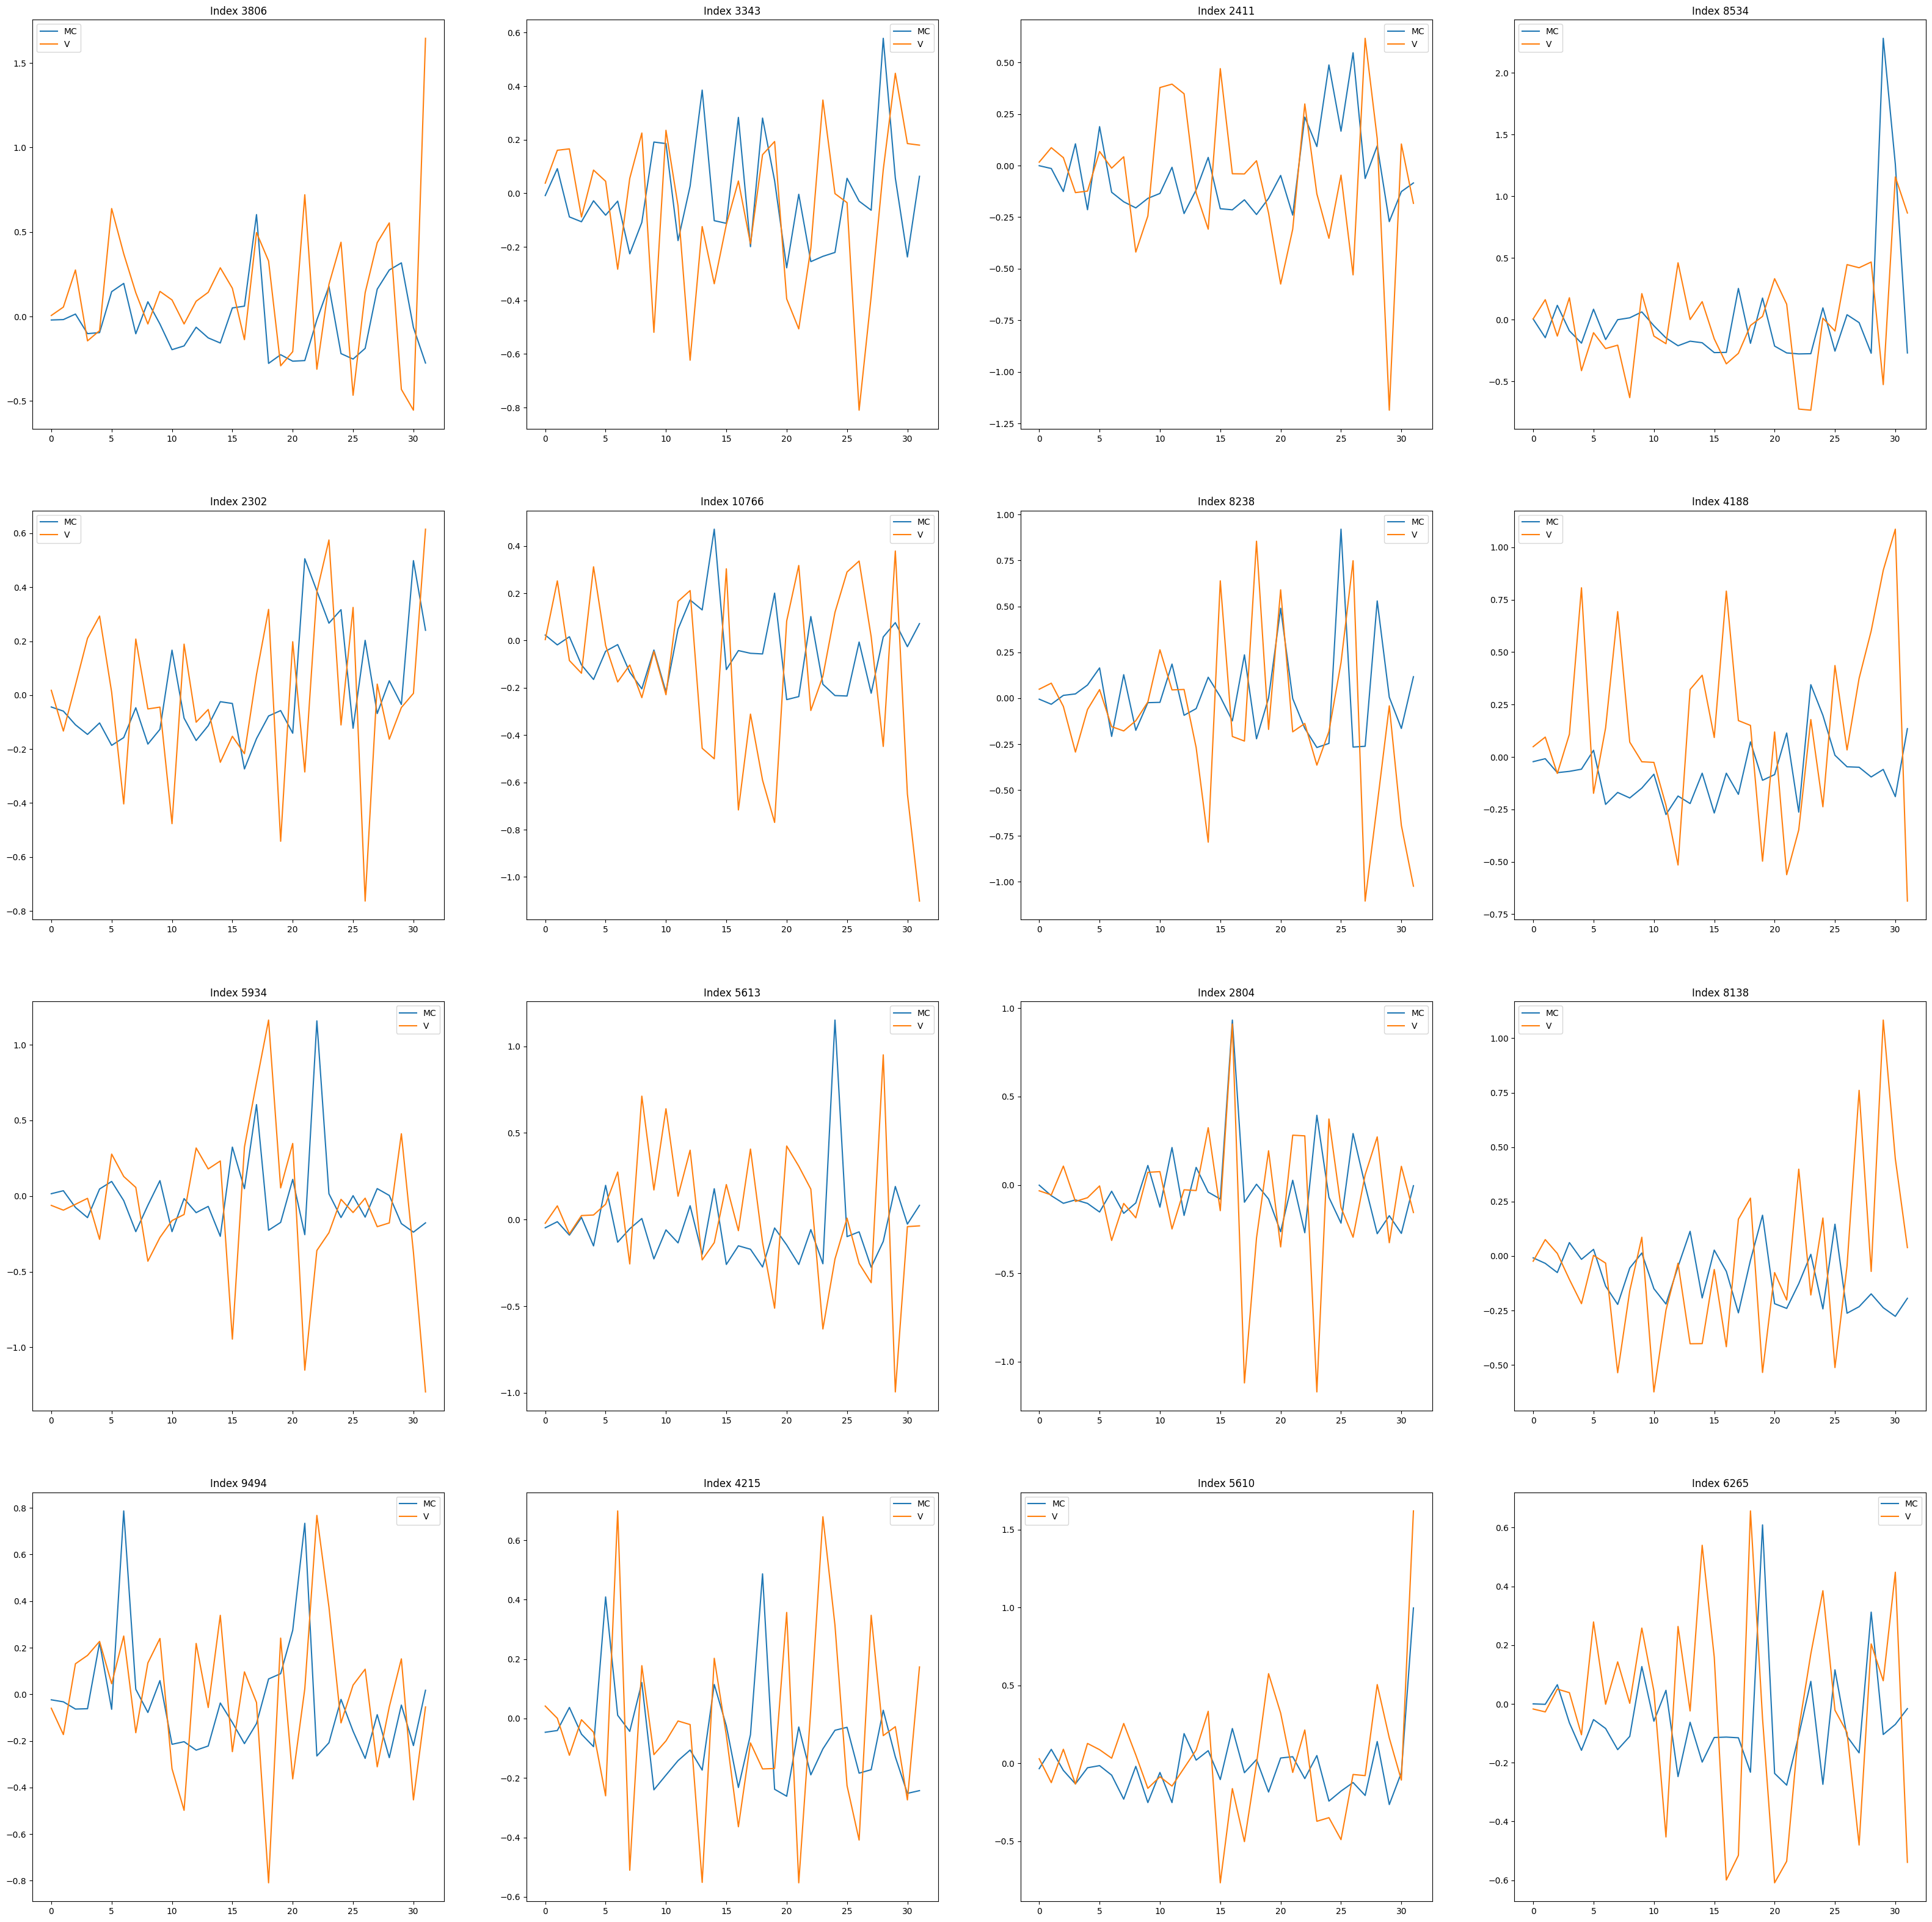

In [157]:
x = "I want to write a paper by"
x = tokenizer.encode(x, return_tensors="pt").cuda()

probs, MCVs = next_token(llama, x)

fig, ax = plt.subplots(4, 4, figsize=(40, 40))

for l in range(4):
    for k in range(4):
        random_index = torch.randint(0, 11008, (1,)).item()
        coefficients, values = [], []

        for i, MCV in enumerate(MCVs):
            # print("layer number:", i)

            MC = MCV['memory_coefficient'][0]
            V = MCV['value'][0]

            coefficients.append(MC[random_index])
            values.append(V[random_index])


            # print('\n\n\n------------------\n\n\n')

        ax[l, k].plot(coefficients, label="MC")
        ax[l, k].plot(values, label="V")
        ax[l, k].legend()
        ax[l, k].set_title(f"Index {random_index}")